# 3. Volume Reverse
五天价格下跌的变化率大于50天的标准差，且最近五天平均成交量小于五天前的五天平均成交量。

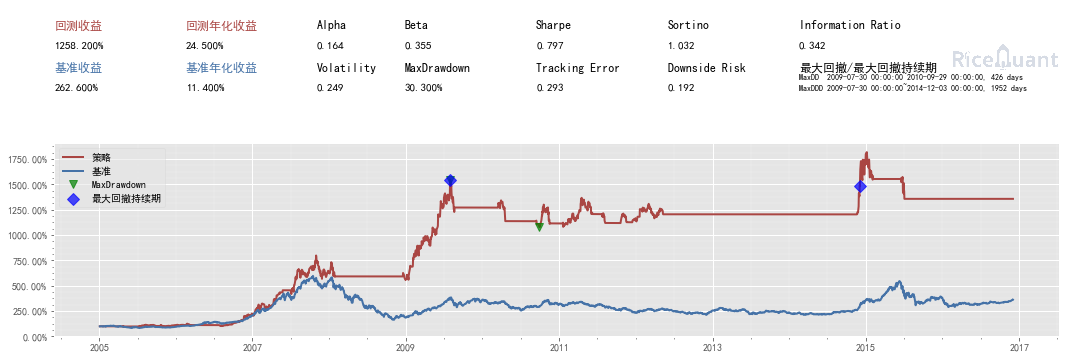

In [1]:
#coding=utf-8
# run_code_demo
from rqalpha import run_code

code = """
import rqalpha
from rqalpha.api import *
import talib
import numpy as np
import os

def init(context):
    context.s1 = "000001.XSHE"
    context.SHORTPERIOD = 5
    context.LONGPERIOD = 50
    context.stoplossmultipler= 0.90 #止损 乘数
    context.takepofitmultipler= 4 #止盈 乘数


def handle_bar(context, bar_dict):
    stop_loss(context, bar_dict)
    prices = history_bars(context.s1, context.LONGPERIOD+1, '1d', 'close')
    volume = history_bars(context.s1, context.LONGPERIOD+1, '1d', 'volume')

    if len(prices)>context.LONGPERIOD:
        SD_P_C = talib.STDDEV(prices, context.LONGPERIOD)
        P_C = np.abs(prices[-1]-prices[-5])
        cond1 = prices[-1]<prices[-5]
        adv = talib.MA(volume[-5:], context.SHORTPERIOD)
        adv_shift = talib.MA(volume[-10:-5], context.SHORTPERIOD)
        cur_position = context.portfolio.positions[context.s1].quantity
        shares = context.portfolio.cash/bar_dict[context.s1].close
        EMA_S = talib.EMA(prices, 15)
        EMA_L = talib.EMA(prices, context.LONGPERIOD)

        if EMA_S[-1] < EMA_L[-1] and EMA_S[-2] > EMA_L[-2]:
            order_target_value(context.s1, 0)
        if cond1 and P_C > SD_P_C[-1] and adv[-1] < 0.65*adv_shift[-1] and cur_position==0:
            order_shares(context.s1, shares)

def stop_loss(context,bar_dict):
    for stock in context.portfolio.positions:
        if bar_dict[stock].last<context.portfolio.positions[stock].avg_price*context.stoplossmultipler:# 现价低于 原价一定比例
            order_target_percent(stock,0)
        elif bar_dict[stock].last>context.portfolio.positions[stock].avg_price*context.takepofitmultipler:# 现价高于原价一定比例
            order_target_percent(stock,0)

"""

config = {
  "base": {
    "start_date": "2000-06-01",
    "end_date": "2016-12-01",
    "securities": ['stock'],
    "stock_starting_cash": 1000000,
    "benchmark": "000300.XSHG"
#     "strategy_file_path": os.path.abspath(__file__)
  },
  "extra": {
    "log_level": "verbose",
  },
  "mod": {
    "sys_analyser": {
      "enabled": True,
      "plot": True
    }
  }
}

# 您可以指定您要传递的参数
run_code(code, config)